In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
from afqinsight.nn.pt_models import Autoencoder, VariationalAutoencoder, Conv1DVariationalAutoencoder, Conv1DAutoencoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




In [2]:
# FA FLATTENED DATASET
# NON VARIATIONAL 
# FC AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [3]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')
from utils import train_variational_autoencoder, train_autoencoder, select_device, prep_fa_flattned_data

In [4]:
device = select_device()

Using device: mps

Using MPS backend on macOS. (Detailed memory info may not be available.)


In [5]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [6]:
torch_dataset, all_tracts_train_loader, all_tracts_test_loader, all_tracts_val_loader = prep_fa_flattned_data(dataset,batch_size=64)

FA indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [7]:
print(f"shape of data", all_tracts_train_loader.dataset[0][0].shape, all_tracts_train_loader.dataset[0][1].shape)
print("Train dataset size:", len(all_tracts_train_loader.dataset))
print("Test dataset size:", len(all_tracts_test_loader.dataset))
print("Validation dataset size:", len(all_tracts_val_loader.dataset))

shape of data torch.Size([1, 100]) torch.Size([3])
Train dataset size: 28656
Test dataset size: 8976
Validation dataset size: 7176


In [ ]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = Autoencoder(input_shape=100, latent_dims=latent_dim, dropout=dropout).to(device)
    
        # Train the model 
        training_results = train_autoencoder(test_model, all_tracts_train_loader, all_tracts_val_loader, 1, 0.001, device=device)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")



Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x100 and 50x50)

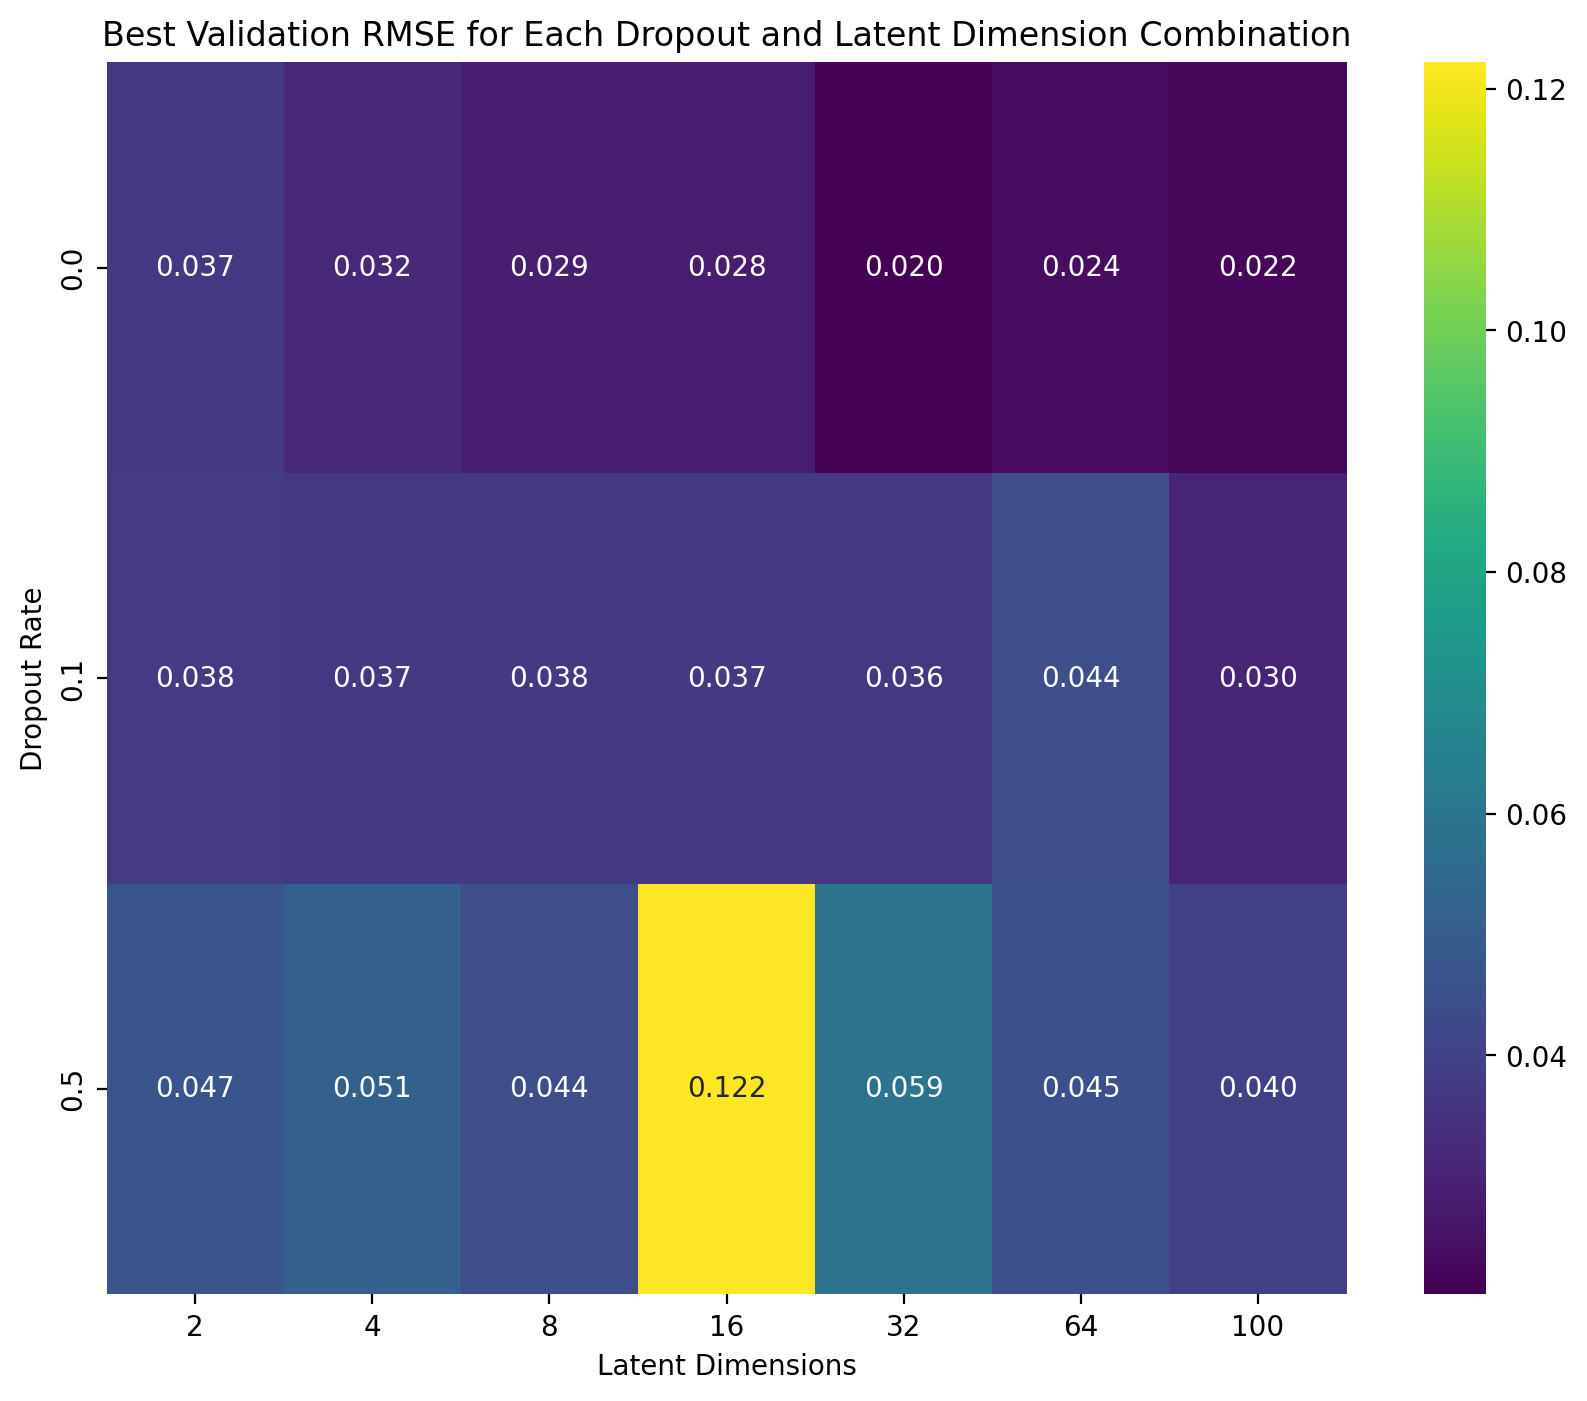

In [9]:
# Create a DataFrame with rows for dropout and columns for latent_dims
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
         best_val_loss = results[(latent_dim, dropout)]["best_val_rmse"]
         df_best_val.loc[dropout, latent_dim] = best_val_loss

# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()


In [10]:
#selecting the model with 64 latent dimensions, 0.1 dropout
sample = all_tracts_test_loader.dataset[0][0][0:1].to(device)
output = models[64, 0.1](sample)
print(sample.shape)

# Assuming the first element of the tuple is the reconstruction:
reconstructed = output[0]

orig = sample.cpu().detach().numpy()
recon = reconstructed.cpu().detach().numpy()


torch.Size([1, 50])


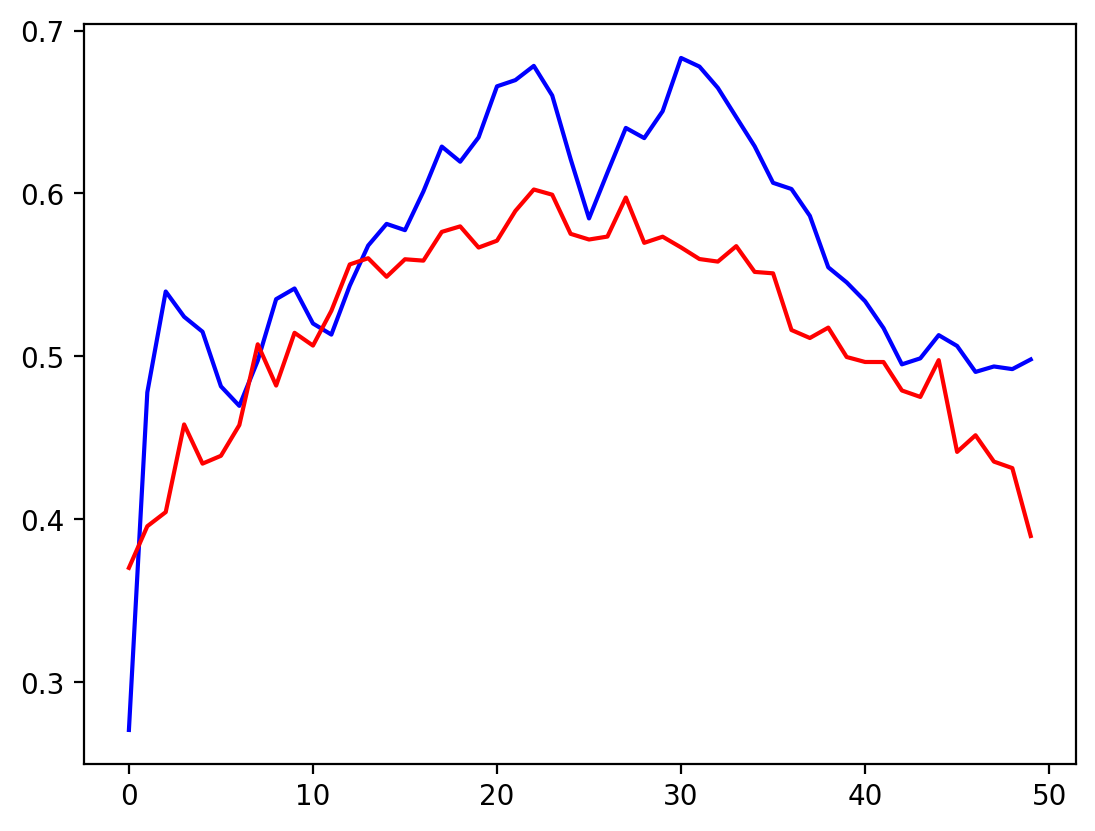

In [11]:
plt.plot(orig.flatten()[0:100], color='blue', label='Original')
plt.plot(recon.flatten()[0:100], color='red', label='Reconstructed')